In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [4]:


named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        society_and_medicine =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world
    )


In [17]:
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle:world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    filter(Genre_Present == 1) %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Day_Present == 1) %>%
    mutate(abs_pos_neg_ratio = (global_rate_positive_words*avg_positive_polarity)/abs(global_rate_negative_words*avg_negative_polarity)) %>%
    filter(global_rate_positive_words != 0 & global_rate_negative_words != 0) %>%
    mutate(Genre = as_factor(Genre)) %>%
    mutate(Day_Of_Week = as_factor(Day_Of_Week)) %>%
    select(Genre, Day_Of_Week, shares)

head(tidy_data)

Genre,Day_Of_Week,shares
<fct>,<fct>,<dbl>
entertainment,monday,593
business,monday,711
business,monday,1500
entertainment,monday,1200
technology,monday,505
technology,monday,855


In [19]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.6, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)


#grouped by the genre so we can summarize the total articles from that genre, the average shares of that genre and the positive to negative word ratio of that genre

Genre,Day_Of_Week,shares
<fct>,<fct>,<dbl>
entertainment,monday,593
business,monday,711
entertainment,monday,1200
technology,monday,855
technology,monday,891
world,monday,710


In [22]:
share_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 

share_recipe <- recipe(shares ~ ., data = publishing_train)



In [23]:
shares_vfold <- vfold_cv(publishing_train, v = 5, strata = shares)


share_workflow <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec)

gridvals <- tibble(neighbors = 1:250) %>%
    filter(neighbors %% 5 == 0 )

share_results <- share_workflow %>%
    tune_grid(resamples = shares_vfold, grid = gridvals) %>%
    collect_metrics()

share_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,rmse,standard,1.092929e+04,5,1.850184e+03,Model01
5,rsq,standard,2.340180e-04,5,1.086154e-04,Model01
10,rmse,standard,1.085616e+04,5,1.880532e+03,Model02
10,rsq,standard,3.553675e-04,5,1.230977e-04,Model02
15,rmse,standard,1.082887e+04,5,1.890577e+03,Model03
15,rsq,standard,6.443795e-04,5,2.767052e-04,Model03
20,rmse,standard,1.080578e+04,5,1.887449e+03,Model04
20,rsq,standard,7.068478e-04,5,3.484345e-04,Model04
25,rmse,standard,1.079541e+04,5,1.888623e+03,Model05


In [24]:
share_min <- share_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1)

share_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
195,rmse,standard,10735.27,5,1878.01,Model39


In [25]:
k_min <- share_min %>%
          pull(neighbors)

share_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

share_best_fit <- workflow() %>%
          add_recipe(share_recipe) %>%
          add_model(share_best_spec) %>%
          fit(data = publishing_train)

share_summary <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test) %>%
           metrics(truth = shares, estimate = .pred)
share_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6.109777e+03
rsq,standard,1.811027e-03
mae,standard,2.472031e+03


In [40]:
share_preds <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test)

options(repr.plot.width = 15, repr.plot.height = 15)

share_plot <- ggplot(share_preds, aes(x = Day_Of_Week, y = shares)) +
  geom_point(alpha = 0.1) +
  labs(x="Day of the Week")+
  geom_point(data = share_preds, aes(x = Day_Of_Week, y = .pred), color = "red")+
  facet_grid(~ Genre)+
  ggtitle("Shares by Day of Week")

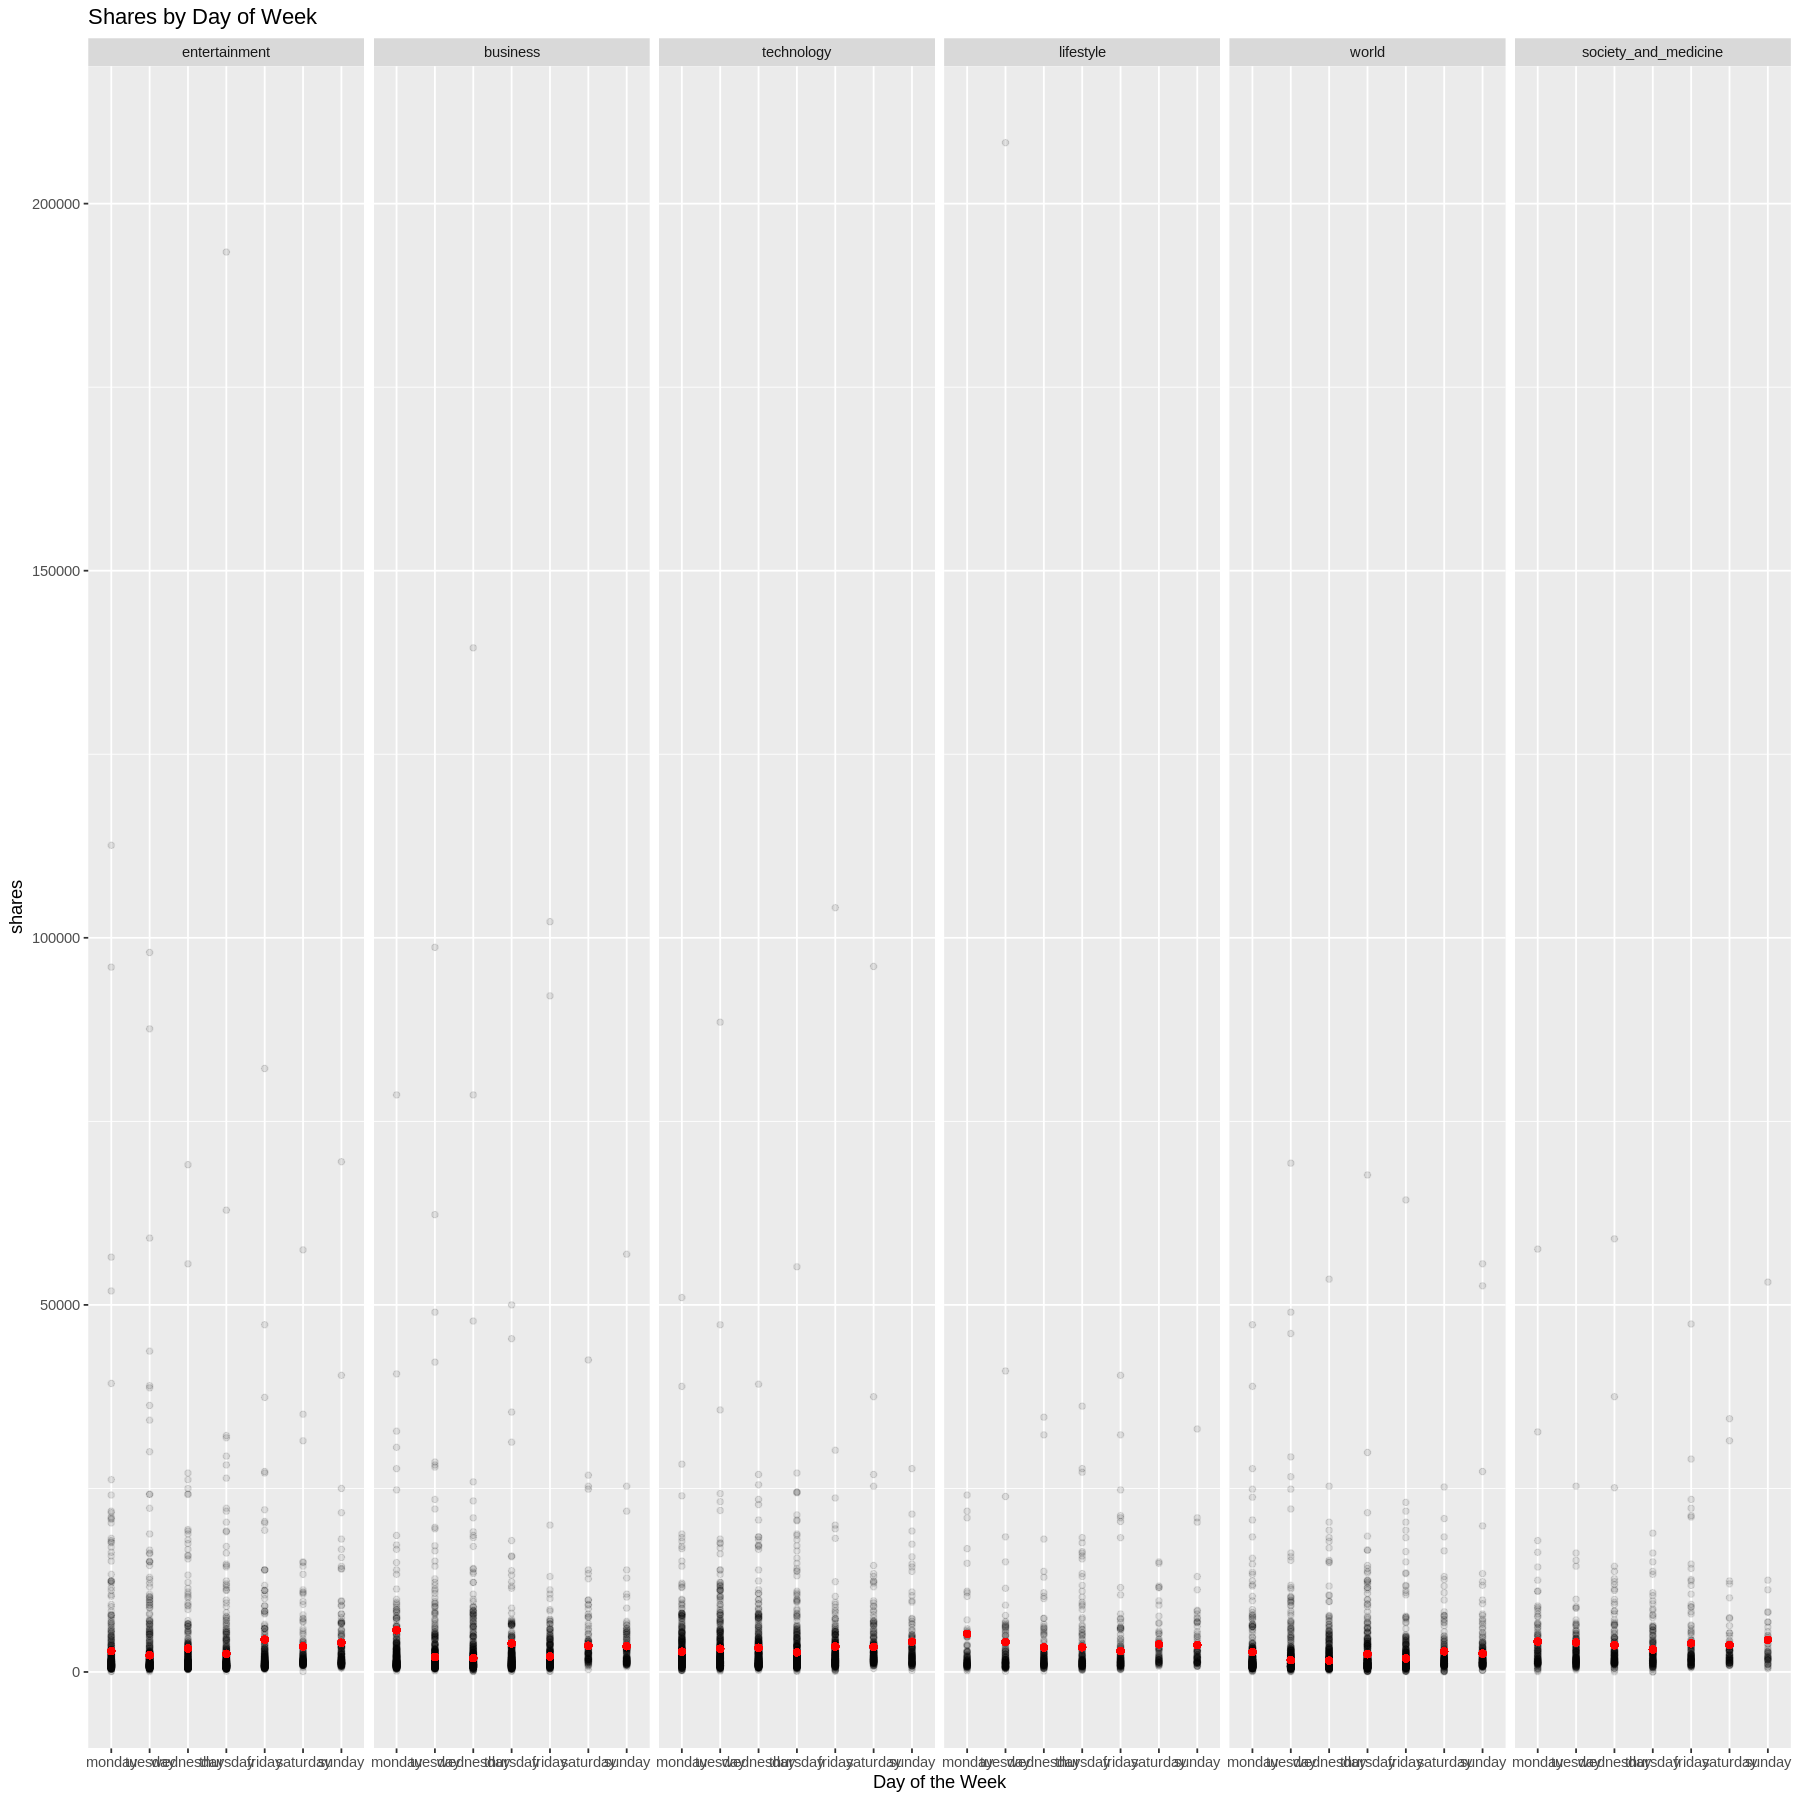

In [41]:
share_plot